**Nama : Rafa Fadil Aras**

**NIM : 2341720007**

**Kelas : TI-3G**

# **Jobsheet 15 : Pipeline Machine Learning & Deployment**

## **Praktikum 2 : Deployment ke Hugging Face (Docker + Flask)**

### **Langkah 1 - Persiapan Environment**

Langkah pertama adalah menyiapkan struktur direktori kerja dan memastikan file model tersedia.


1. Buat folder baru di komputer Anda dengan nama daynight-project.

    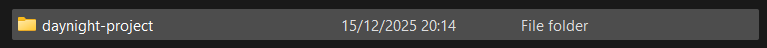

2. Cari file model (day_night_model.h5) dan scaler (scaler.pkl) hasil training dari praktikum sebelumnya.

3. Pindahkan kedua file tersebut ke dalam folder daynight-project.

    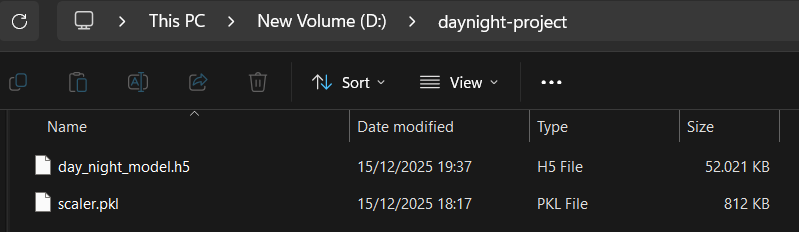

4. Buka terminal (Git Bash atau CMD), lalu arahkan direktori ke folder tersebut.

    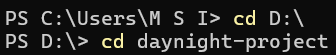



### **Langkah 2 - Konfigurasi Server (app.py)**

Diperlukan aplikasi web sederhana menggunakan Flask untuk menangani request gambar dari pengguna.

1. Buat file baru bernama app.py di dalam folder proyek.

    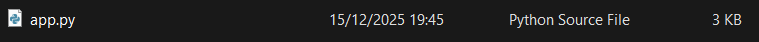

2. Salin kode berikut ke dalamnya (kode ini memuat model dan melakukan preprocessing HOG yang sama persis dengan saat training) :

In [ ]:
import os
import numpy as np
import cv2
import pickle
import tensorflow as tf
from flask import Flask, request, render_template_string
from skimage.feature import hog

app = Flask(__name__)

# Load Model & Scaler
MODEL_PATH = 'day_night_model.h5'
SCALER_PATH = 'scaler.pkl'

try:
    model = tf.keras.models.load_model(MODEL_PATH)
    with open(SCALER_PATH, 'rb') as f:
        scaler = pickle.load(f)
    print("✅ System Loaded Successfully")
except Exception as e:
    print(f"❌ Error loading system: {e}")

def preprocess_image(image_bytes):
    # Decode gambar
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Preprocessing (Harus sama persis dengan Training)
    img = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8,8),
                   cells_per_block=(2,2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    return scaler.transform(hog_feat.reshape(1, -1))

@app.route('/', methods=['GET'])
def home():
    return render_template_string('''
    <div style="text-align:center; padding:50px;">
        <h1>Day vs Night Classifier</h1>
        <form action="/predict" method="post" enctype="multipart/form-data">
            <input type="file" name="file" required><br><br>
            <button type="submit">Prediksi</button>
        </form>
    </div>
    ''')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        file = request.files['file']
        data = preprocess_image(file.read())
        prediction = model.predict(data)[0][0]

        label = "Day (Siang)" if prediction > 0.5 else "Night (Malam)"
        return f"<h2 style='text-align:center'>Hasil: {label}</h2><center><a href='/'>Kembali</a></center>"
    except Exception as e:
        return f"Error: {e}"

if __name__ == '__main__':
    # Port 7860 wajib untuk Hugging Face Spaces
    app.run(host='0.0.0.0', port=7860)

### **Langkah 3 - Konfigurasi Dependencies (requirements.txt)**

Agar server cloud tahu library apa saja yang dibutuhkan, perlu membuat daftar dependencies.

1. Buat file baru bernama requirements.txt.

    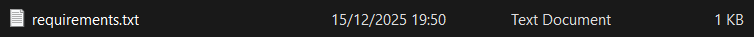

2. Isi file tersebut dengan daftar library berikut :

    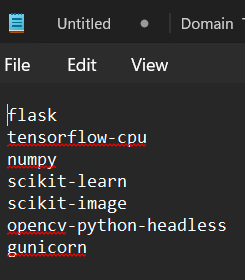



### **Langkah 4 - Konfigurasi Docker (Dockerfile)**

Dockerfile berisi instruksi untuk membangun image sistem operasi yang akan menjalankan aplikasi kita.

1. Buat file bernama Dockerfile (tanpa ekstensi file apapun).

    image.png

2. Salin konfigurasi berikut :

In [ ]:
# Base Image Python 3.9 Slim
FROM python:3.9-slim

# Install Library Sistem untuk OpenCV (Debian Bookworm/Trixie Compatible)
RUN apt-get update && apt-get install -y \
    libgl1 \
    libglib2.0-0 \
    && rm -rf /var/lib/apt/lists/*

# Setup User Non-Root (Standar Keamanan HF)
RUN useradd -m -u 1000 user
USER user
ENV PATH="/home/user/.local/bin:$PATH"

# Setup Direktori Kerja
WORKDIR /app

# Install Dependencies
COPY --chown=user ./requirements.txt requirements.txt
RUN pip install --no-cache-dir --upgrade -r requirements.txt

# Copy File Aplikasi
COPY --chown=user . /app

# Expose Port & Jalankan
EXPOSE 7860
CMD ["python", "app.py"]

### **Langkah 5 - Setup Hugging Face Space**

Sekarang perlu membuat wadah untuk aplikasi ini di Hugging Face.


1. Login ke akun Hugging Face.

    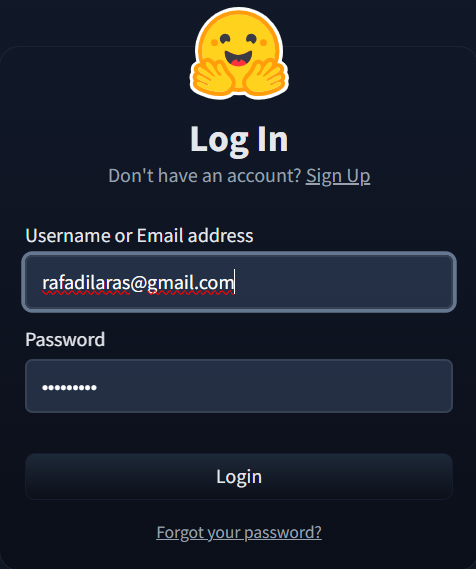

2. Klik foto profil di pojok kanan atas, lalu pilih New Space.

    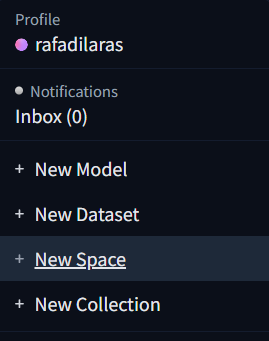

3. Isi konfigurasi berikut:

    - Space Name: daynight-classifier-namaanda (ganti namaanda dengan nama/NIM anda).

    - License: Apache 2.0/ MIT.

    - Space SDK: Pilih Docker.

    - Template: kosongi

    - Visibility: Public.

    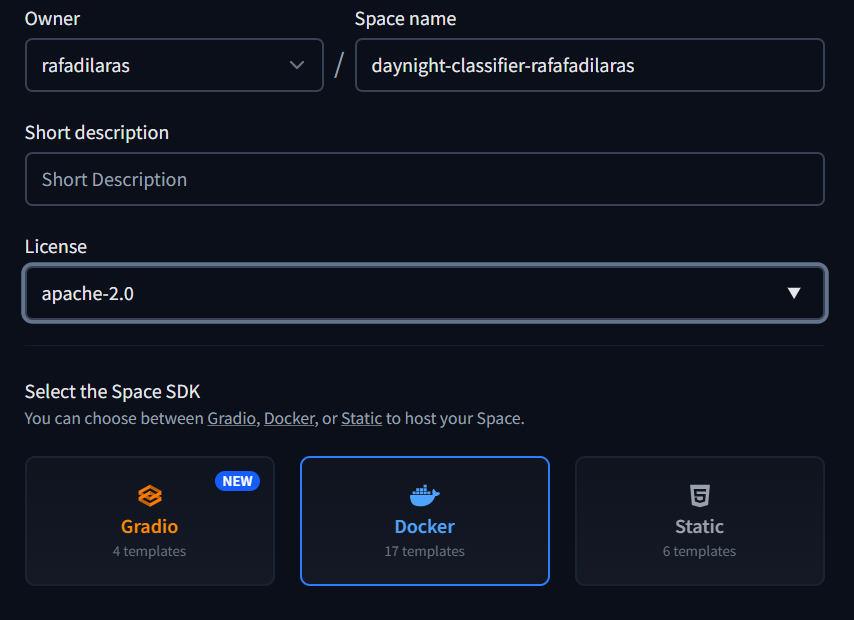

    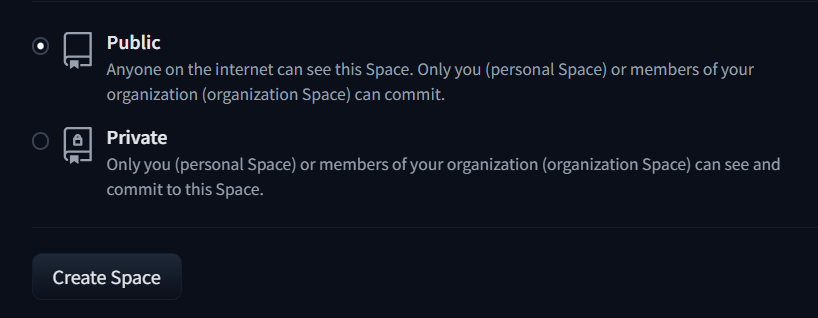

4. Klik tombol Create Space.

5. Buat Access Token untuk izin upload.

    - Masuk ke Settings > Access Tokens.

    - Klik Create new token.

    - Pilih permission Write.

    - Salin token tersebut (simpan di notepad sementara).

    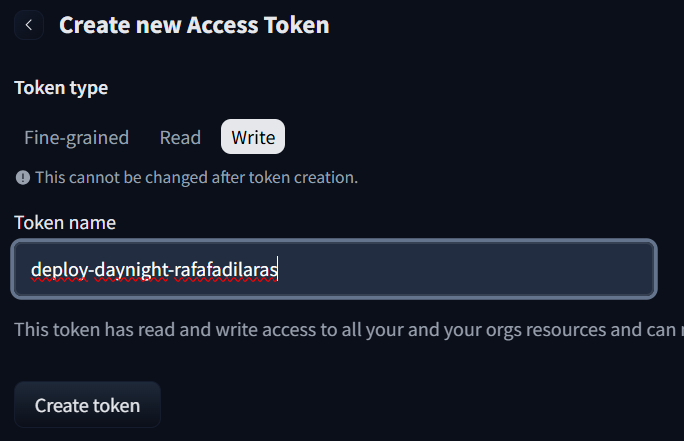

    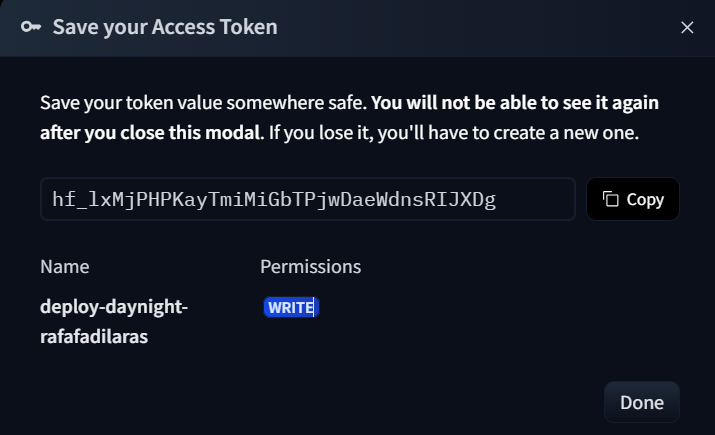

### **Langkah 6 - Upload ke Cloud (Hugging Face)**

Pada langkah ini, akan dilakukan dengan cara men-download repository kosong dari Hugging Face ke komputer, mengisi file-nya, lalu mengunggahnya kembali.

1. Clone Repository

    Buka terminal (Git Bash) di direktori tempat Anda ingin menyimpan proyek, lalu jalankan perintah berikut untuk mengambil repository dari Hugging Face:

    # Ganti USERNAME_ANDA dan NAMA_SPACE dengan milik Anda
      git clone https://huggingface.co/spaces/USERNAME_ANDA/NAMA_SPACE

      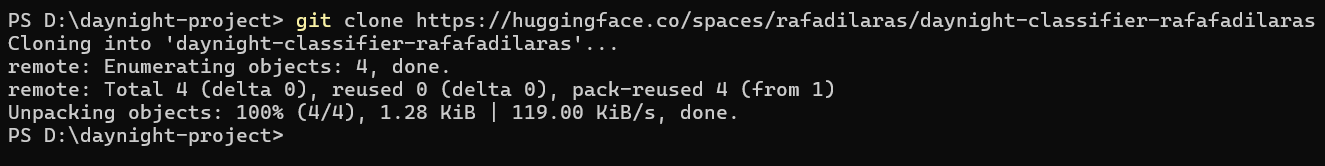

      2. Pindahkan File ke Folder Repository

    Setelah perintah di atas selesai, akan muncul folder baru di perangkat anda dengan nama Space Anda.

      - Buka File Explorer.

      - Salin/Pindahkan semua file yang sudah Anda siapkan sebelumnya (app.py, Dockerfile, requirements.txt, svm_hog_linear.joblib, dan scaler.joblib) ke dalam folder baru hasil clone tersebut.

      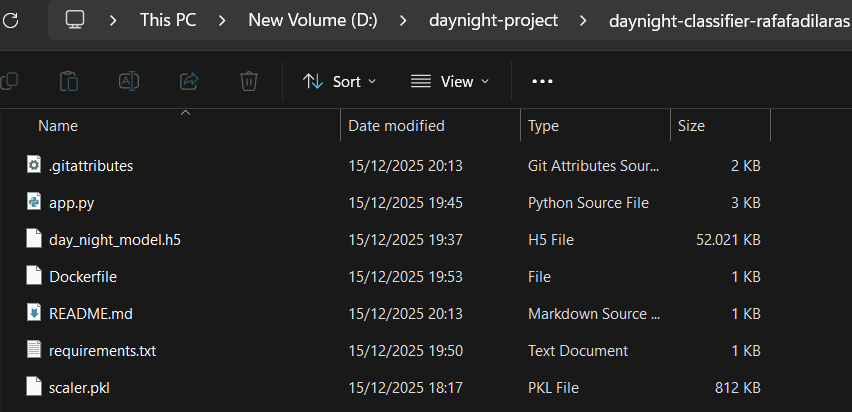

3. Upload File ke Hugging Face

    Kembali ke terminal, masuk ke dalam folder yang baru saja di-clone, lalu lakukan proses upload :

    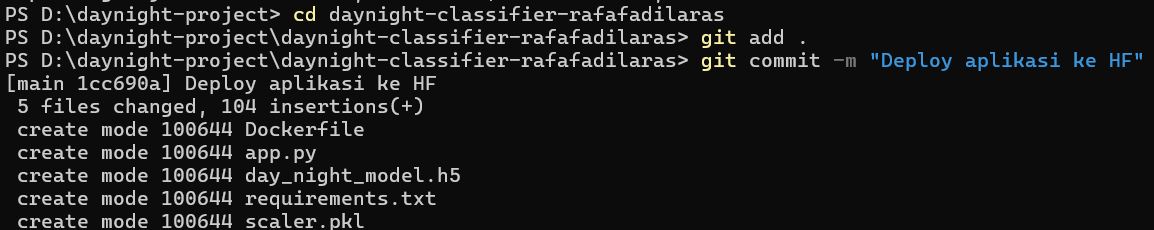

    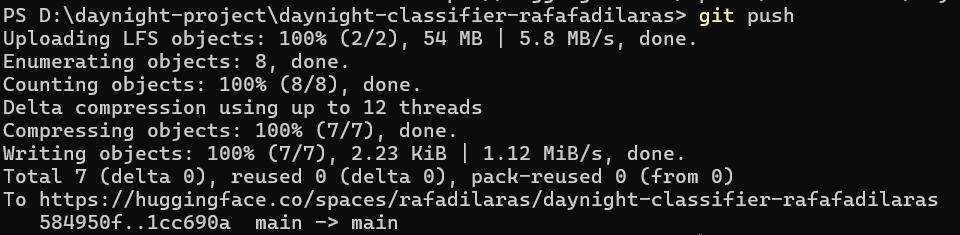

4. Autentikasi (Password = Token)

    Saat perintah git push dijalankan, terminal akan meminta kredensial:

    - Username: Masukkan username Hugging Face Anda (misal: VAHFirdaus).

    - Password: JANGAN masukkan password login akun, namun Copy dan Paste Access Token yang sudah Anda buat di Langkah 5 dan telah anda simpan di notepad tadi.

    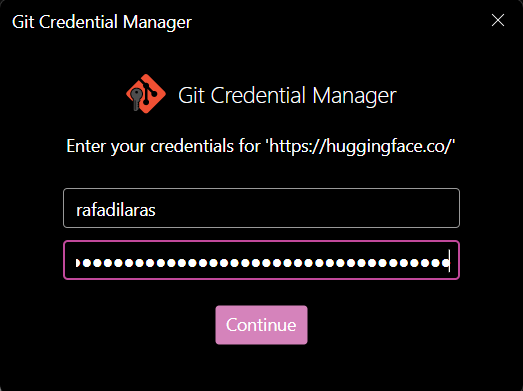

    

### **Langkah 7 - Pengujian dan Hasil Akhir**

Setelah proses git push selesai 100%:

1. Kembali ke browser, buka halaman Space Anda.

2. Klik tab App.

3. Jika sudah Running, upload gambar tes (angka multidigt) dan pastikan prediksi berjalan lancar.

**Maka, Hasilnya :**

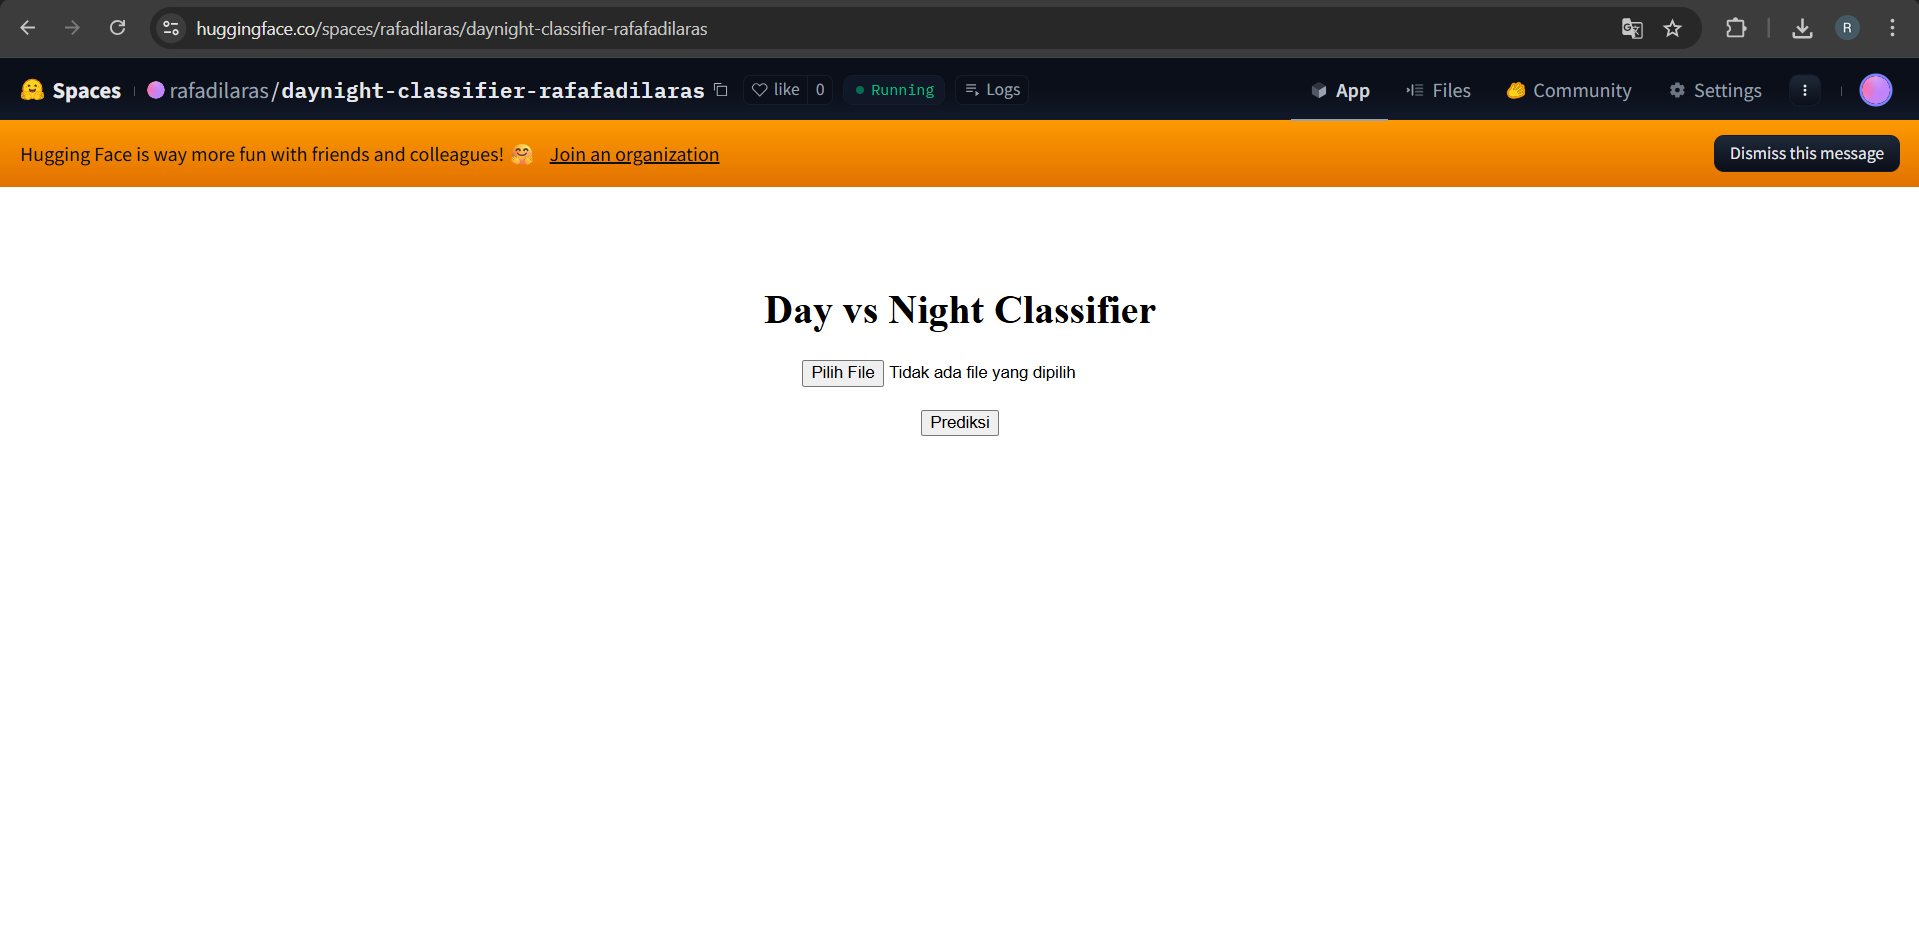

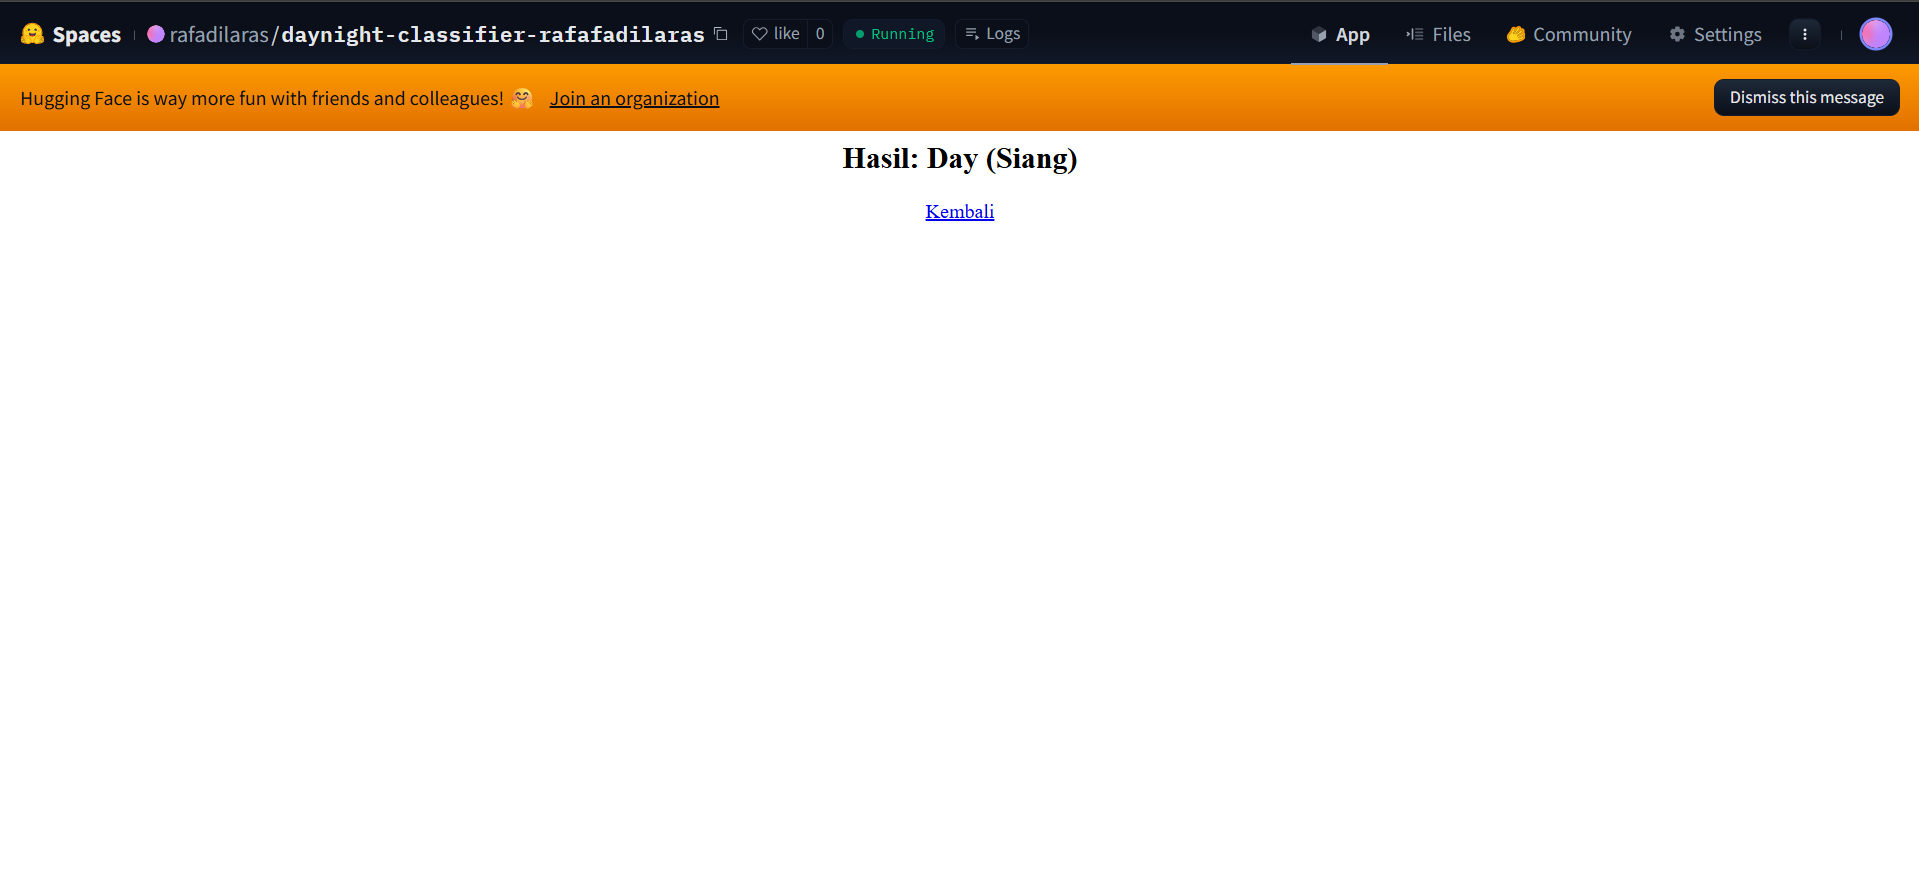